In [1]:
import os

N_THREADS = "4"
os.environ["OMP_NUM_THREADS"] = N_THREADS
os.environ["OPENBLAS_NUM_THREADS"] = N_THREADS
os.environ["MKL_NUM_THREADS"] = N_THREADS
os.environ["VECLIB_MAXIMUM_THREADS"] = N_THREADS
os.environ["NUMEXPR_NUM_THREADS"] = N_THREADS

In [2]:
import gEconpy as ge
import numpy as np
import pandas as pd
import gEconpy.plotting as gp
import matplotlib.pyplot as plt

In [3]:
mod = ge.model_from_gcn("../GCN Files/sims_2024/nk_taylor_rule_linearized.gcn")

Model Building Complete.
Found:
	12 equations
	12 variables
		The following variables were eliminated at user request:
			D_t, TC_t, T_t, U_t, Y_j_t
		The following "variables" were defined as constants and have been substituted away:
			B_t
	3 stochastic shocks
		 0 / 3 has a defined prior. 
	12 parameters
		 11 / 12 parameters has a defined prior. 
	0 parameters to calibrate.
Model appears well defined and ready to proceed to solving.



In [4]:
mod.steady_state()

{'A_ss': 1.0,
 'C_ss': 0.9764540896763105,
 'N_ss': 0.9764540896763105,
 'SDF_ss': 0.99,
 'Y_ss': 0.9764540896763105,
 'cost_push_shock_ss': 0.0,
 'i_ss': 0.010101010101010166,
 'interest_shock_ss': 1.0,
 'lambda_ss': 1.0740994986439416,
 'mc_ss': 0.9090909090909092,
 'pi_ss': 1.0,
 'w_ss': 0.9090909090909092}

In [5]:
pi_bar_values = np.linspace(-0.005, 0.01, 100)
ss_pi_bar = pd.DataFrame(
    [mod.steady_state(pi_bar=1 + pi_bar, sigma=1.0) for pi_bar in pi_bar_values],
    index=pi_bar_values,
)

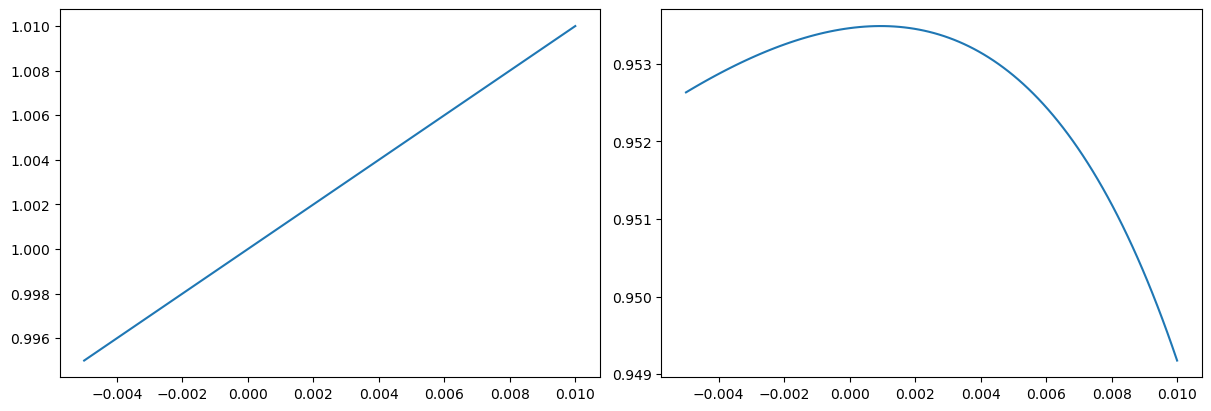

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, layout="constrained")
variables = ["pi_ss", "Y_ss"]
for var, axis in zip(variables, fig.axes):
    ss_pi_bar[var].plot(ax=axis)
plt.show()

In [7]:
irf_params = {
    "beta": 0.99,
    "sigma": 3.0,
    "chi": 1,
    "theta": 1,
    "phi": 3 / 4,
    "epsilon": 11,
    "pi_bar": 1.0,
    "rho_A": 0.9,
    "rho_i": 0.5,
    "phi_pi": 1.5,
    "phi_Y": 0.5,
}
irf = ge.impulse_response_function(
    mod,
    **irf_params,
    shock_size={"epsilon_A": 0.01, "epsilon_i": 0.01},
    simulation_length=20,
    log_linearize=False,
)

Solution found, sum of squared residuals: 0.000000000
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


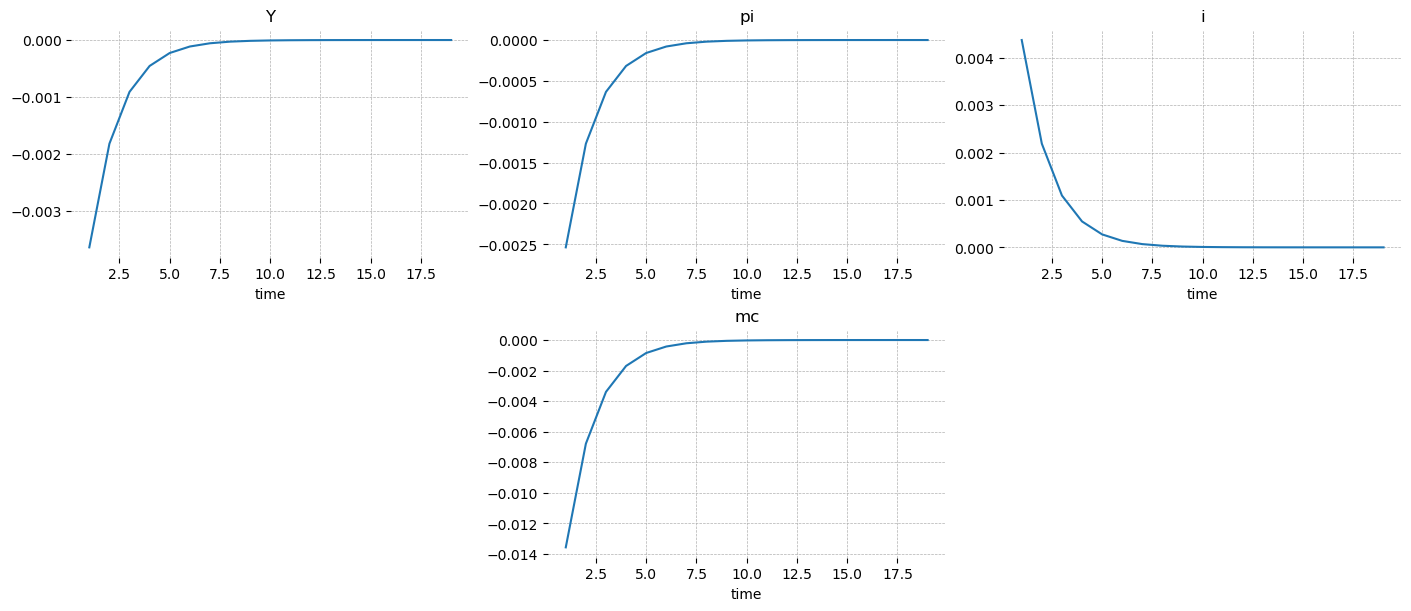

In [8]:
import gEconpy.plotting as gp

gp.plot_irf(
    irf.isel(time=slice(1, None)),
    vars_to_plot=["Y", "pi", "i", "mc"],
    shocks_to_plot=["epsilon_i"],
    n_cols=3,
    figsize=(14, 6),
);

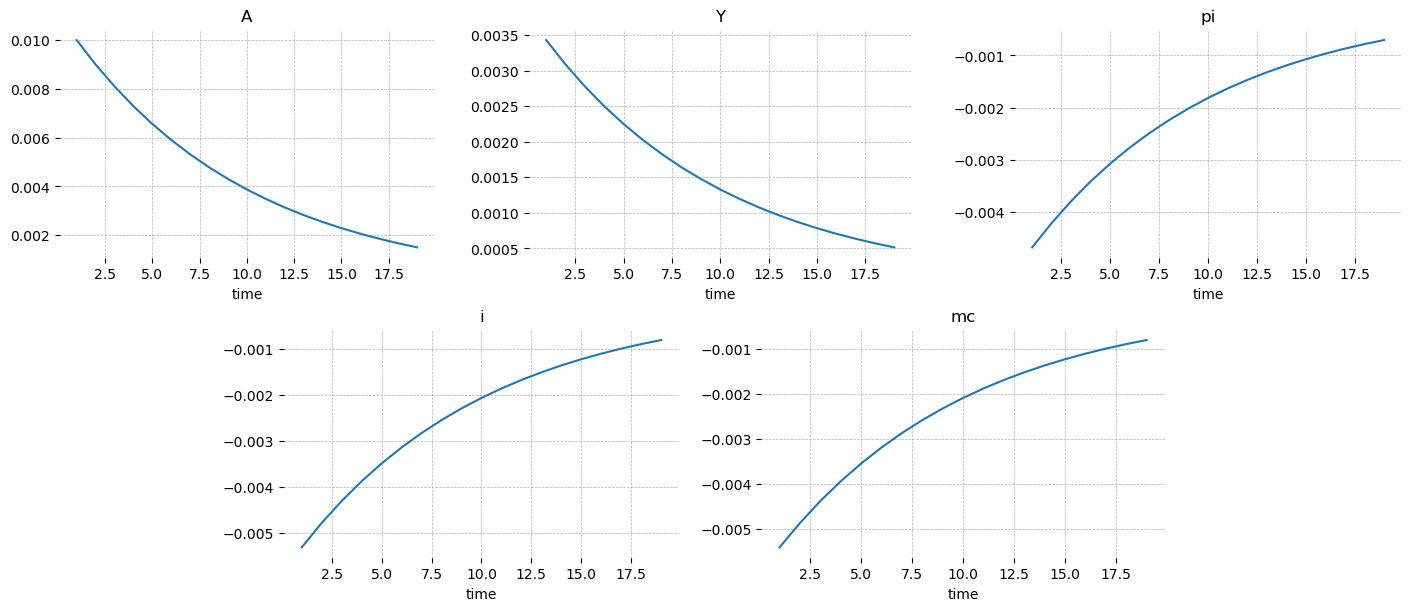

In [9]:
gp.plot_irf(
    irf.isel(time=slice(1, None)),
    vars_to_plot=["A", "Y", "pi", "i", "mc"],
    shocks_to_plot=["epsilon_A"],
    n_cols=3,
    figsize=(14, 6),
);

In [10]:
irf_by_phi = {
    f"phi = {phi}": ge.impulse_response_function(
        mod,
        **(irf_params | {"phi": phi, "pi_bar": 1.0}),
        shock_size={"epsilon_A": 0.01, "epsilon_i": 0.01},
        simulation_length=20,
        log_linearize=False,
        verbose=False,
    ).isel(time=slice(1, None))
    for phi in [0.1, 0.75, 0.9]
}

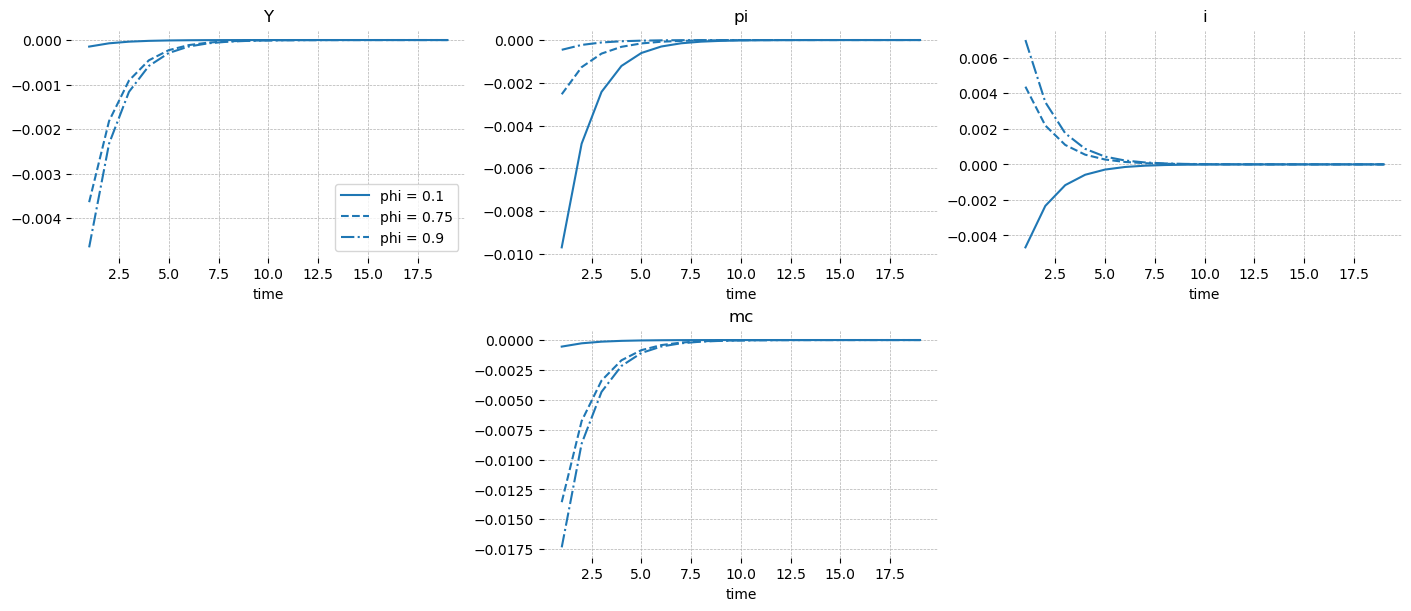

In [11]:
gp.plot_irf(
    irf_by_phi,
    vars_to_plot=["Y", "pi", "i", "mc"],
    shocks_to_plot=["epsilon_i"],
    n_cols=3,
    figsize=(14, 6),
);

The following variables had steady-state values close to zero and will not be log-linearized:['cost_push_shock_t']
Solution found, sum of squared residuals: 0.000000000
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


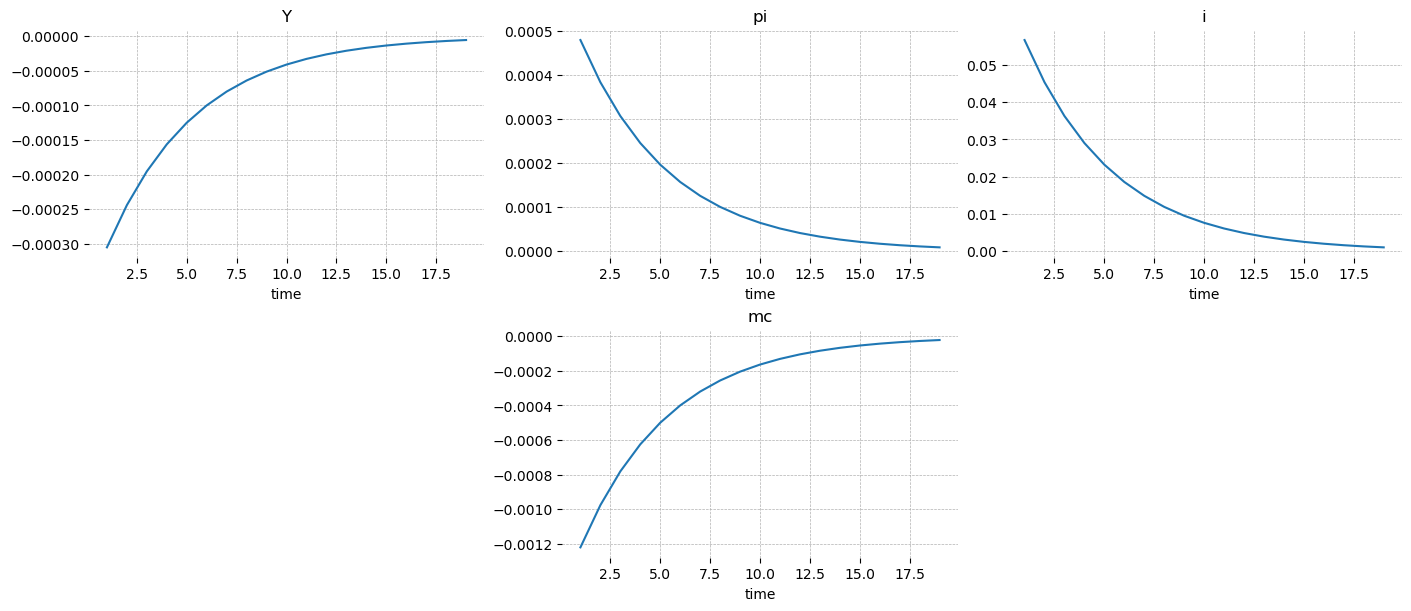

In [12]:
irf = ge.impulse_response_function(
    mod,
    phi=0.1,
    shock_size={"epsilon_p": 0.01},
    simulation_length=20,
    log_linearize=True,
)
gp.plot_irf(
    irf.isel(time=slice(1, None)),
    vars_to_plot=["Y", "pi", "i", "mc"],
    shocks_to_plot=["epsilon_p"],
    n_cols=3,
    figsize=(14, 6),
);

In [18]:
T, R = mod.solve_model(log_linearize=True)

The following variables had steady-state values close to zero and will not be log-linearized:['cost_push_shock_t']
Solution found, sum of squared residuals: 0.000000000
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [19]:
ge.matrix_to_dataframe(T, mod).round(3)

,A,C,N,SDF,Y,cost_push_shock,i,interest_shock,lambda,mc,pi,w
A,0.900,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0
C,0.316,0.0,0.0,0.0,0.0,-1.194,0.0,-0.187,0.0,0.0,0.0,0.0
N,-0.584,0.0,0.0,0.0,0.0,-1.194,0.0,-0.187,0.0,0.0,0.0,0.0
SDF,-0.948,0.0,0.0,0.0,0.0,3.581,0.0,0.560,-1.0,0.0,0.0,0.0
Y,0.316,0.0,0.0,0.0,0.0,-1.194,0.0,-0.187,0.0,0.0,0.0,0.0
cost_push_shock,0.000,-0.0,-0.0,-0.0,-0.0,0.800,-0.0,-0.000,-0.0,-0.0,-0.0,-0.0
i,-47.425,-0.0,-0.0,-0.0,-0.0,221.685,-0.0,21.644,-0.0,-0.0,-0.0,-0.0
interest_shock,-0.000,-0.0,-0.0,-0.0,-0.0,0.000,-0.0,0.500,-0.0,-0.0,-0.0,-0.0
lambda,-0.948,0.0,0.0,0.0,0.0,3.581,0.0,0.560,0.0,0.0,0.0,0.0
mc,-0.535,-0.0,-0.0,-0.0,-0.0,-4.775,-0.0,-0.746,-0.0,-0.0,-0.0,-0.0


In [18]:
ge.matrix_to_dataframe(R, mod).round(3)

,epsilon_A,epsilon_i,epsilon_p
A,1.000,0.000,0.000
C,0.351,-0.373,-1.492
N,-0.649,-0.373,-1.492
SDF,-1.054,1.119,4.476
Y,0.351,-0.373,-1.492
cost_push_shock,-0.000,0.000,1.000
i,-52.694,43.288,277.107
interest_shock,-0.000,1.000,0.000
lambda,-1.054,1.119,4.476
mc,-0.595,-1.493,-5.968


In [22]:
ss_mod = ge.statespace_from_gcn("../GCN Files/sims_2024/nk_taylor_rule_linearized.gcn")

Model Building Complete.
Found:
	12 equations
	12 variables
		The following variables were eliminated at user request:
			D_t, TC_t, T_t, U_t, Y_j_t
		The following "variables" were defined as constants and have been substituted away:
			B_t
	3 stochastic shocks
		 0 / 3 has a defined prior. 
	12 parameters
		 11 / 12 parameters has a defined prior. 
	0 parameters to calibrate.
Model appears well defined and ready to proceed to solving.

Statespace model construction complete, but call the .configure method to finalize.


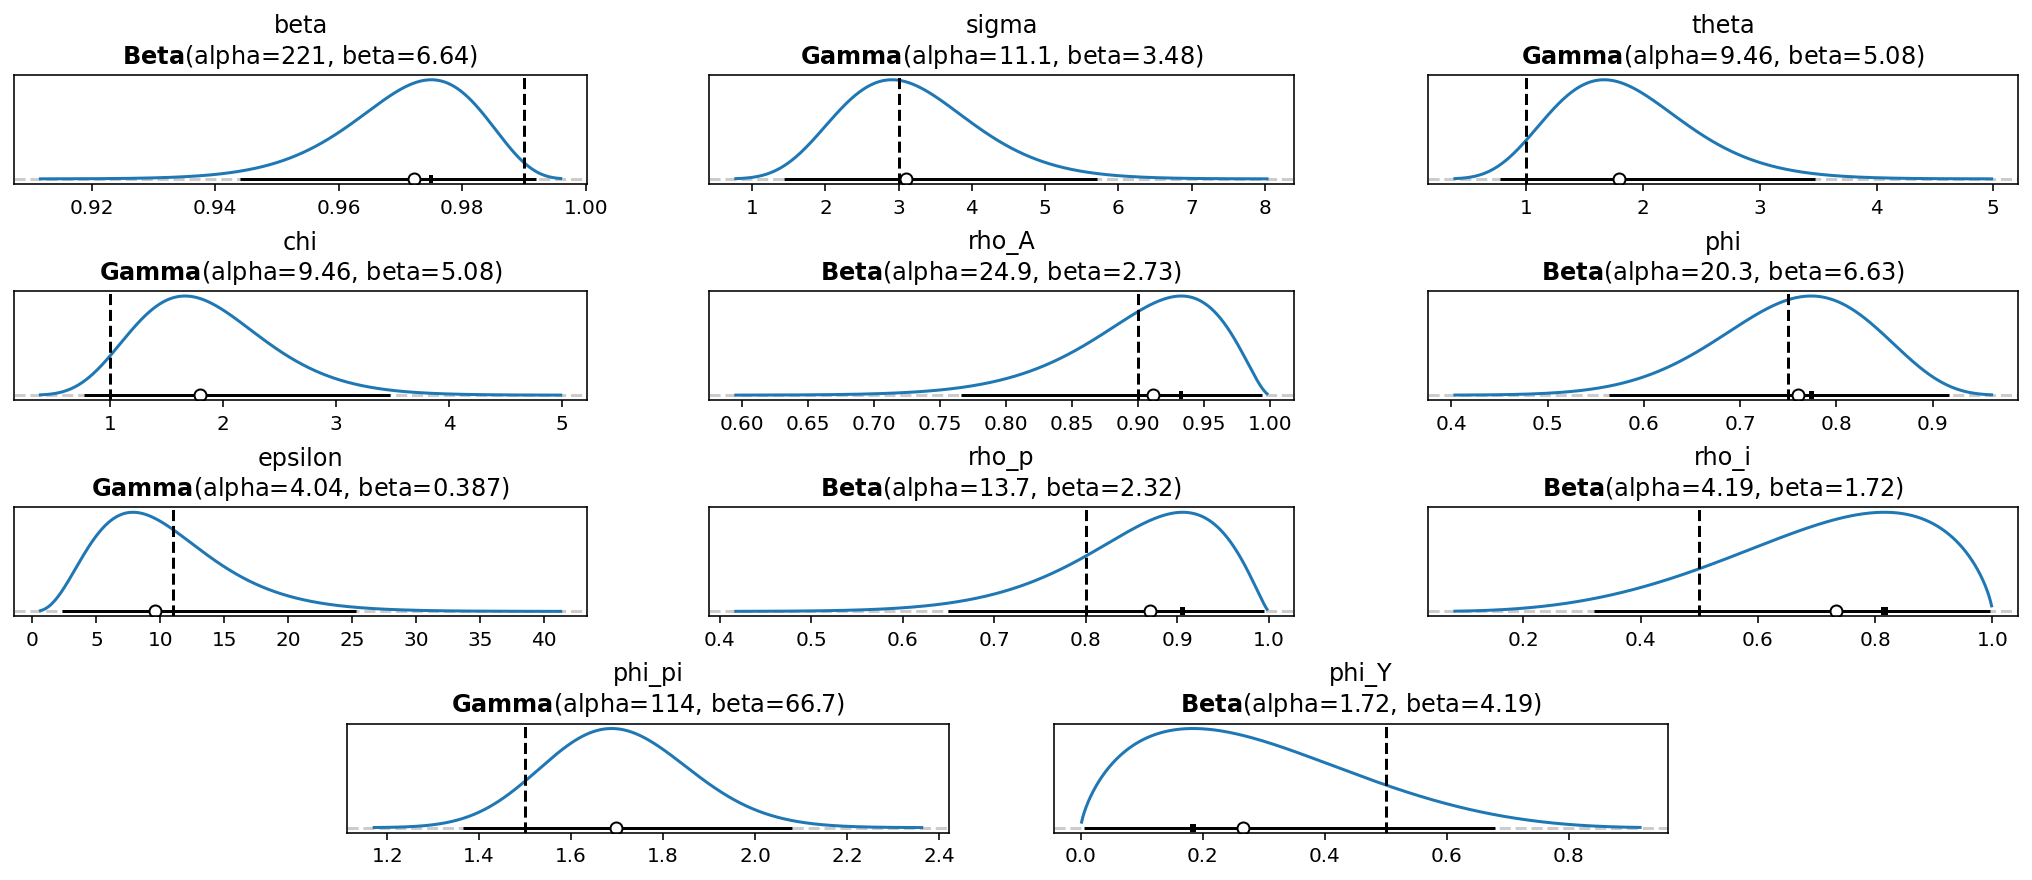

In [23]:
gp.plot_priors(ss_mod, n_cols=3);

In [26]:
ss_mod.configure(
    observed_states=["Y", "C", "N", "pi", "i", "w"],
    measurement_error=["Y", "C", "N", "w"],
    constant_params=["pi_bar"],
    full_shock_covaraince=True,
    solver="scan_cycle_reduction",
    mode="JAX",
    max_iter=20,
    use_adjoint_gradients=True,
)

The following parameters should be assigned priors inside a PyMC model block: 
	beta -- shape: (), constraints: None, dims: None
	chi -- shape: (), constraints: None, dims: None
	epsilon -- shape: (), constraints: None, dims: None
	phi -- shape: (), constraints: None, dims: None
	phi_Y -- shape: (), constraints: None, dims: None
	phi_pi -- shape: (), constraints: None, dims: None
	rho_A -- shape: (), constraints: None, dims: None
	rho_i -- shape: (), constraints: None, dims: None
	rho_p -- shape: (), constraints: None, dims: None
	sigma -- shape: (), constraints: Positive, dims: None
	theta -- shape: (), constraints: None, dims: None
	state_cov -- shape: (3, 3), constraints: Positive Semi-Definite, dims: ('shock', 'shock_aux')
	error_sigma_Y -- shape: (), constraints: None, dims: None
	error_sigma_C -- shape: (), constraints: None, dims: None
	error_sigma_N -- shape: (), constraints: None, dims: None
	error_sigma_w -- shape: (), constraints: None, dims: None


In [27]:
import pymc as pm
import preliz as pz

dates = pd.date_range(start="1980-01-01", end="2024-11-01", freq="QS-OCT")
dummy_data = pd.DataFrame(np.nan, index=dates, columns=ss_mod.observed_states)

all_priors = ss_mod.param_priors | ss_mod.shock_priors

with pm.Model(coords=ss_mod.coords) as pm_mod:
    ss_mod.to_pymc()
    for var_name in ss_mod.error_states:
        x = pz.maxent(pz.Gamma(), lower=0.01, upper=0.05, plot=False)
        all_priors[f"error_sigma_{var_name}"] = x
        x.to_pymc(name=f"error_sigma_{var_name}")

    chol, *_ = pm.LKJCholeskyCov(
        "state_chol", n=3, eta=6, sd_dist=pm.HalfNormal.dist(sigma=0.05)
    )
    cov = pm.Deterministic("state_cov", chol @ chol.T, dims=["shock", "shock_aux"])

    ss_mod.build_statespace_graph(
        dummy_data,
        add_bk_check=False,
        add_solver_success_check=True,
        add_norm_check=True,
        add_steady_state_penalty=True,
    )

    prior = pm.sample_prior_predictive()

/Users/jessegrabowski/mambaforge/envs/grabowski_phd/lib/python3.12/site-packages/pymc_extras/statespace/utils/data_tools.py:159: ImputationWarning: Provided data contains missing values and will be automatically imputed as hidden states during Kalman filtering.
  warnings.warn(impute_message, ImputationWarning)
/var/folders/7b/rzxy96cj0w751_6td3g2yss00000gn/T/ipykernel_69605/758441464.py:28: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  prior = pm.sample_prior_predictive()
Sampling: [beta, chi, epsilon, error_sigma_C, error_sigma_N, error_sigma_Y, error_sigma_w, obs, phi, phi_Y, phi_pi, rho_A, rho_i, rho_p, sigma, state_chol, theta]


In [28]:
prior_trajectories = ss_mod.sample_unconditional_prior(prior)

/Users/jessegrabowski/mambaforge/envs/grabowski_phd/lib/python3.12/site-packages/pytensor/link/jax/linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x323E1EDC0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [prior_combined]


Output()

In [29]:
idx = np.random.choice(prior.prior.coords["draw"].values)

true_params = prior.prior.isel(chain=0, draw=idx)
data = prior_trajectories.isel(chain=0, draw=idx).prior_observed
data = (
    data.to_dataframe()
    .drop(columns=["chain", "draw"])
    .unstack("observed_state")
    .droplevel(axis=1, level=0)
)

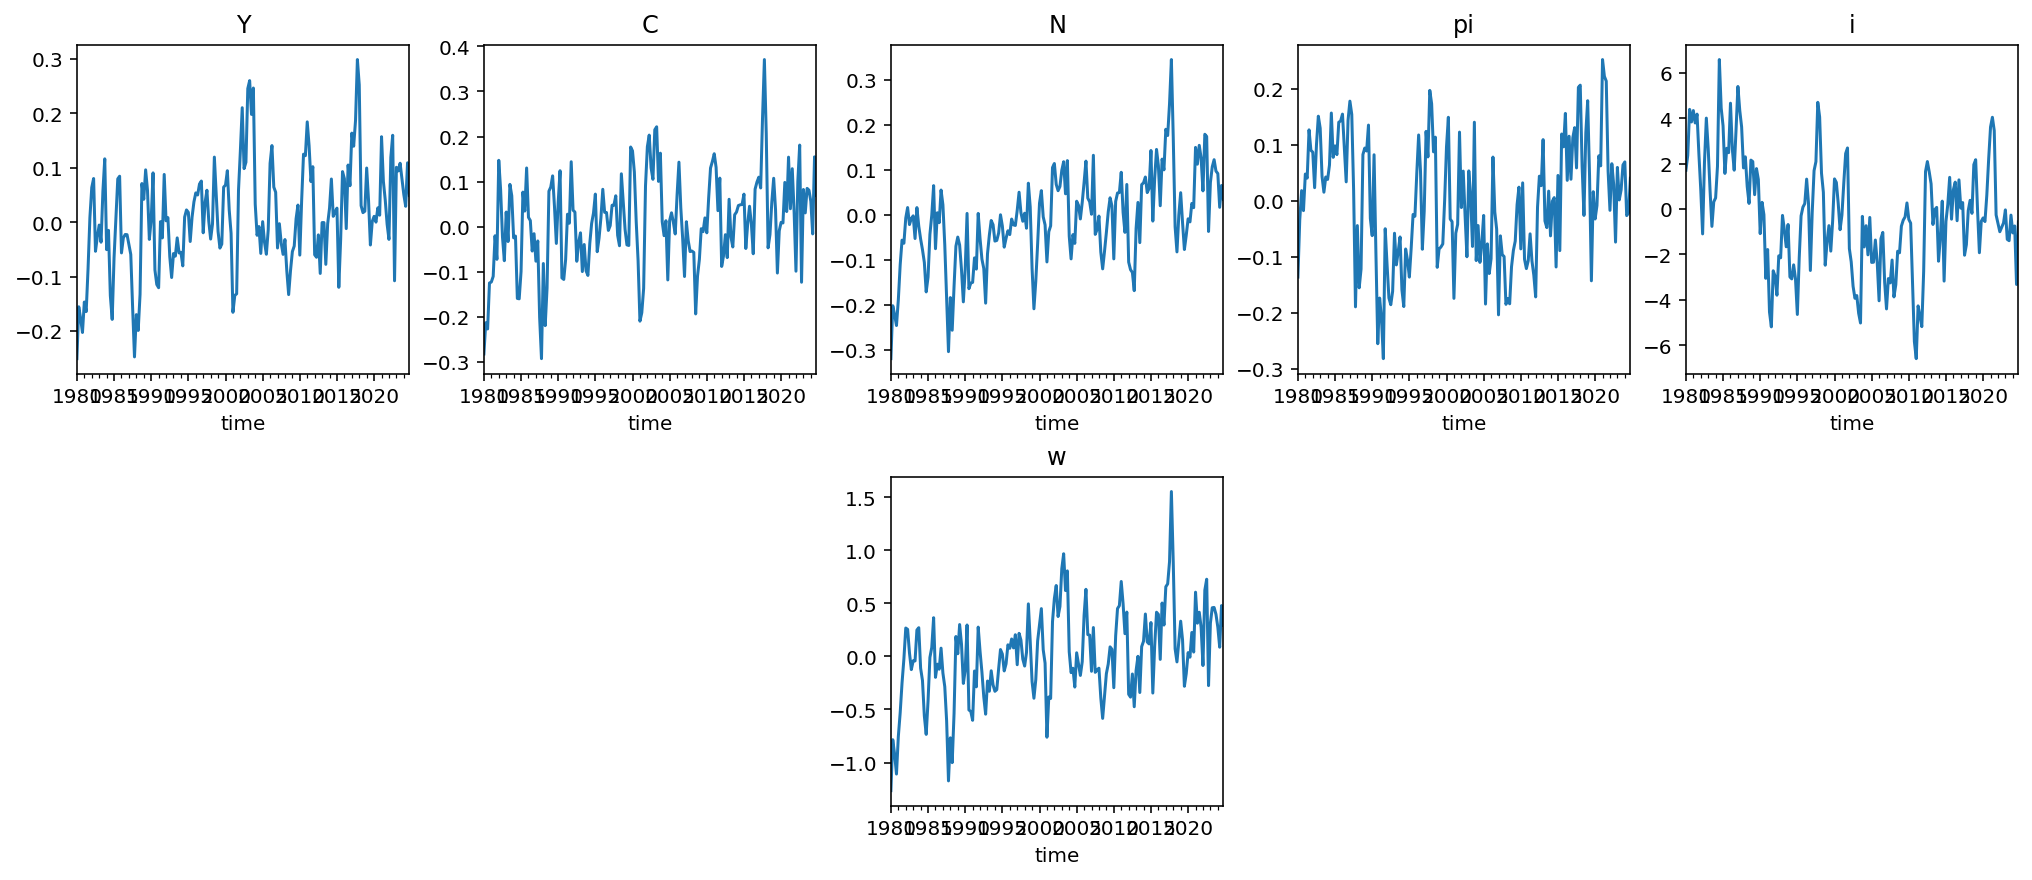

In [30]:
fig = plt.figure(figsize=(14, 6), dpi=144, layout="constrained")
gs, locs = gp.prepare_gridspec_figure(
    n_plots=len(ss_mod.observed_states), n_cols=5, figure=fig
)
for loc, col in zip(locs, data):
    axis = fig.add_subplot(gs[loc])
    data[col].plot(ax=axis, legend=False, title=col)

In [31]:
with pm_mod:
    pm.set_data({"data": data})
    ss_mod._fit_data = data

In [32]:
from pymc.model.transform.optimization import freeze_dims_and_data
import nutpie as ntp

ntp_mod = ntp.compile_pymc_model(
    freeze_dims_and_data(pm_mod),
    backend="jax",
    gradient_backend="jax",
    default_initialization_strategy="prior",
    jitter_rvs=set(),
    initial_points=None,
)

In [33]:
idata = ntp.sample(
    ntp_mod.with_transform_adapt(
        verbose=True,
        learning_rate=1e-4,
        num_layers=10,
        zero_init=False,
        dct_layer=True,
        extend_dct=True,
    ),
    tune=2000,
    draws=1000,
    chains=6,
    transform_adapt=False,
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,3000,2,0.37,31
,3000,0,0.36,31
,3000,3,0.36,15
,3000,1,0.35,15
,3000,1,0.35,15
,3000,5,0.38,31


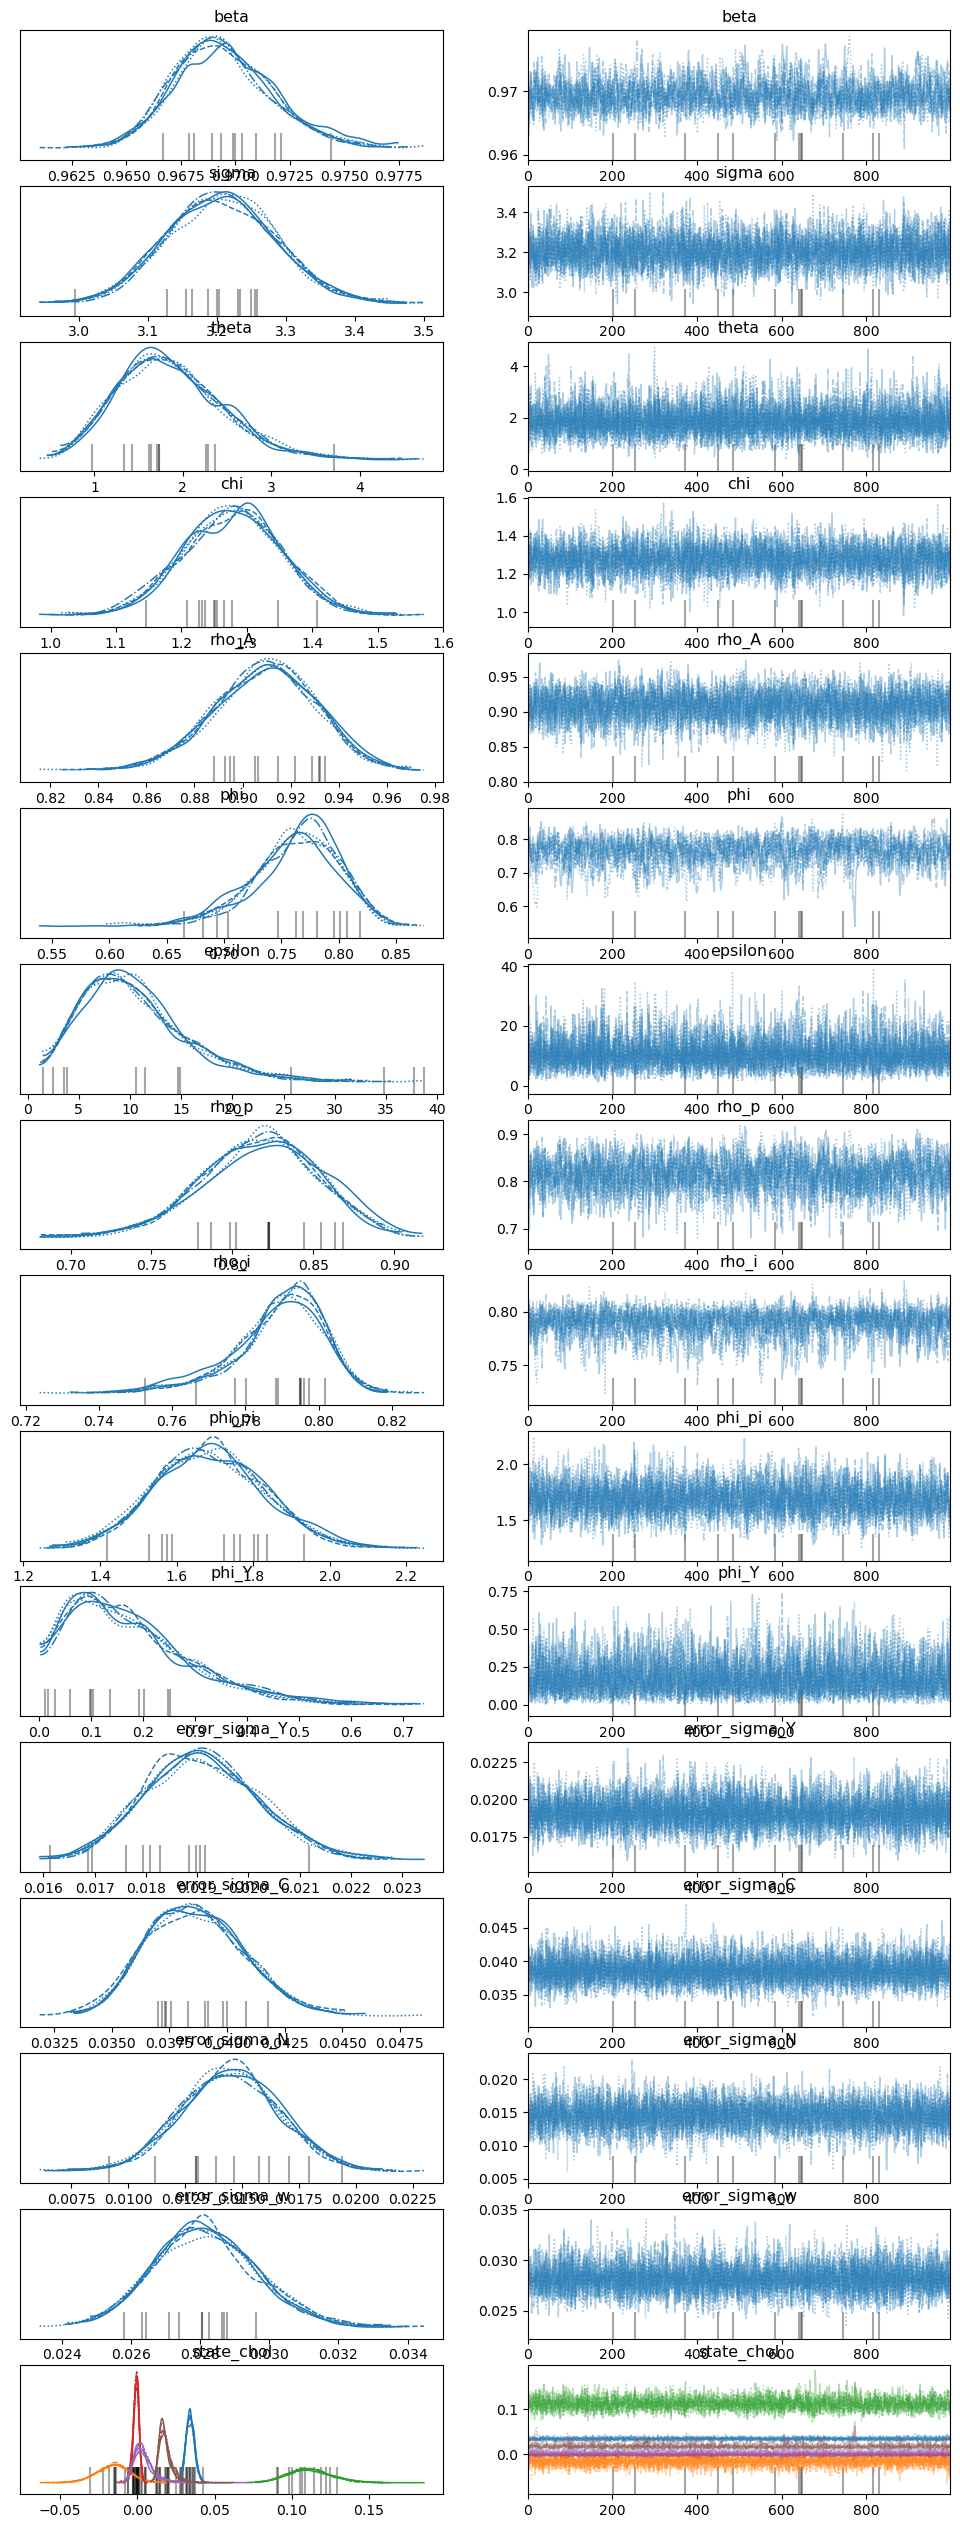

In [34]:
import arviz as az

var_names = [rv.name for rv in pm_mod.free_RVs]
az.plot_trace(idata, var_names=var_names);

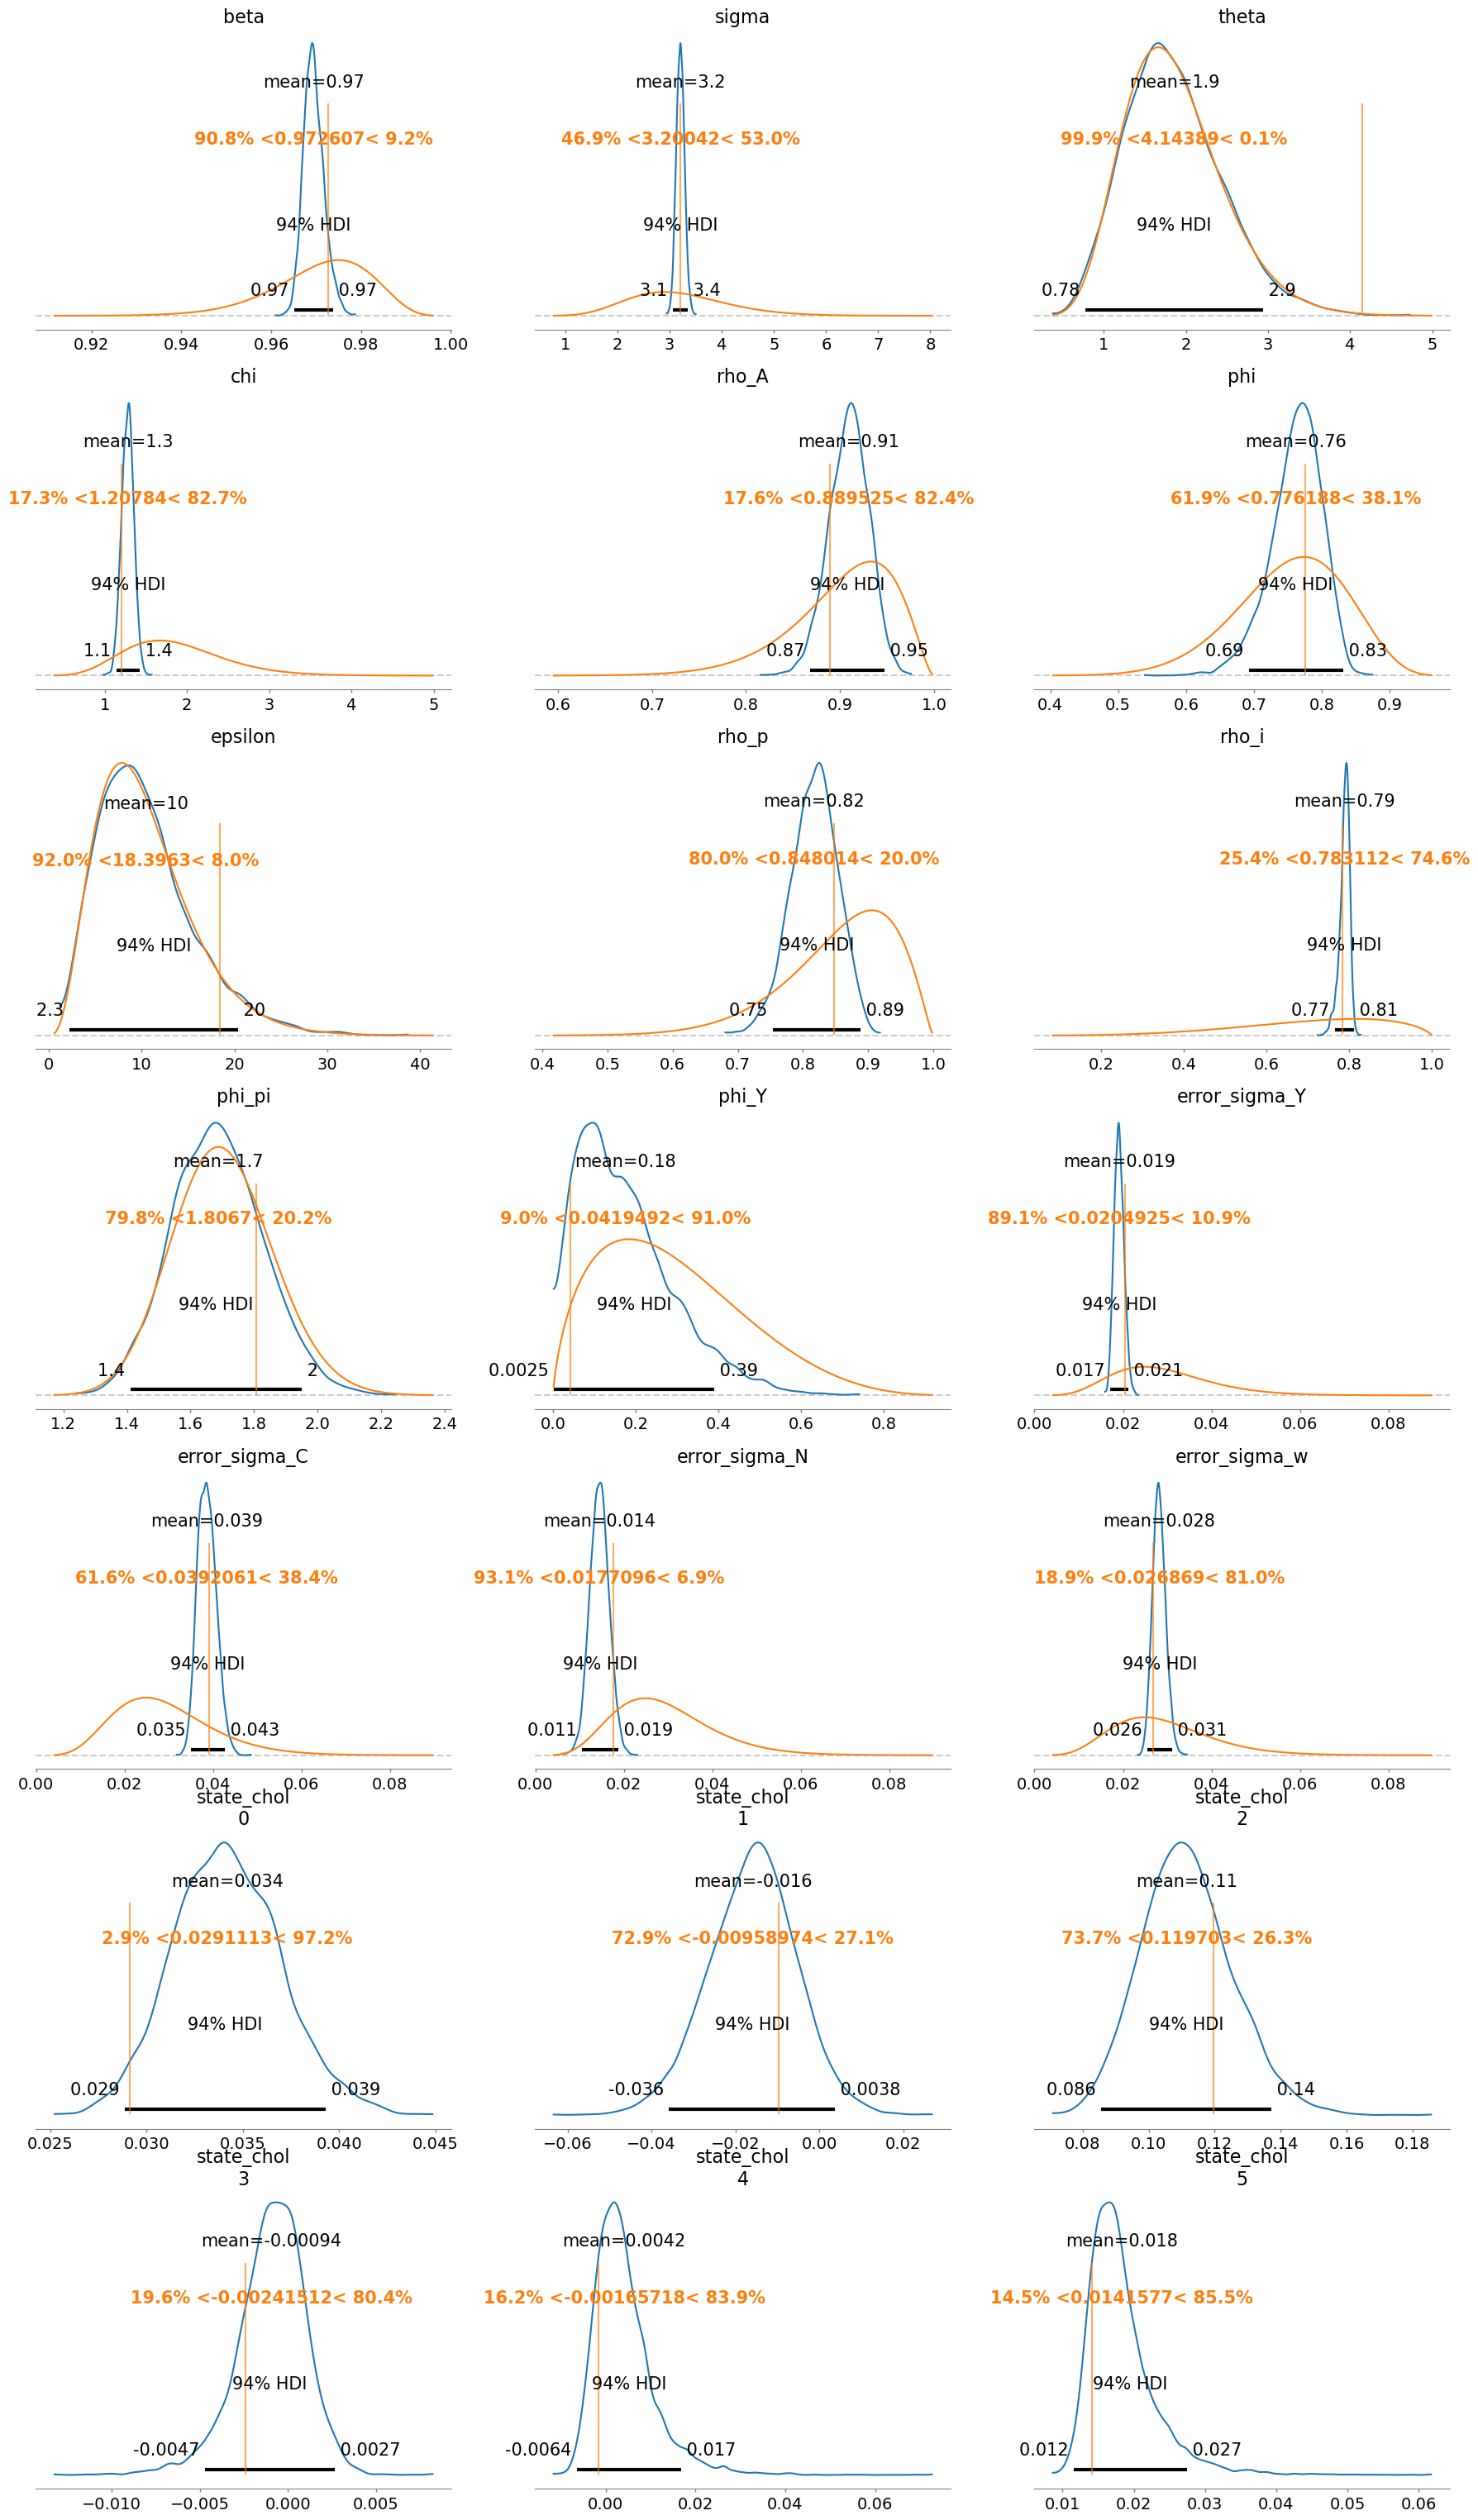

In [35]:
axes = az.plot_posterior(
    idata,
    var_names=var_names,
    ref_val=np.r_[*[true_params[name].values.ravel() for name in var_names]].tolist(),
)
for axis in axes.ravel():
    var_name, *coords = axis.get_title().split("\n")

    if var_name in all_priors:
        all_priors[var_name].plot_pdf(ax=axis, legend=False, color="tab:orange")